# Tutorial video

This notebook regroups the code sample of the video below, which is a part of the [Hugging Face course](https://huggingface.co/course).

In [1]:
from IPython.display import IFrame

IFrame(src="https://www.youtube.com/embed/OATCgQtNX2o?rel=0&amp;controls=0&amp;showinfo=0", width=560, height=315)

# Load embedding model and run on sample sentences

From: <https://www.sbert.net/docs/pretrained_models.html>

The all-* models where trained on all available training data (more than 1 billion training pairs) and are designed as general purpose models. The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality.

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
sentences = [
    "I took my dog for a walk",
    "Today is going to rain",
    "I took my cat for a walk",
    "Today, I took my dog",
]

model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    model_output = model(**encoded_input)


token_embeddings = model_output.last_hidden_state
print(f"Token embeddings shape: {token_embeddings.size()}")

Token embeddings shape: torch.Size([4, 9, 384])


In [4]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

sentence_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])

# Normalize the embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
print(f"Sentence embeddings shape: {sentence_embeddings.size()}")

Sentence embeddings shape: torch.Size([4, 384])


In [5]:
sentence_embeddings = sentence_embeddings.detach().numpy()

scores = np.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0]))

for idx in range(sentence_embeddings.shape[0]):
    scores[idx, :] = cosine_similarity([sentence_embeddings[idx]], sentence_embeddings)[0]

In [6]:
scores

array([[1.00000012, 0.1702117 , 0.82909298, 0.77300024],
       [0.1702117 , 1.        , 0.17396855, 0.28136641],
       [0.82909298, 0.17396855, 1.00000012, 0.60556054],
       [0.77300024, 0.28136641, 0.60556054, 1.        ]])

# Test with more data from online source

In [7]:
from datasets import load_dataset

In [8]:
squad = load_dataset("squad", split="validation").shuffle(seed=42).select(range(100))

def get_embeddings(text_list):
    encoded_input = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v for k, v in encoded_input.items()}
    with torch.no_grad():
        model_output = model(**encoded_input)
    return mean_pooling(model_output, encoded_input["attention_mask"])


squad_with_embeddings = squad.map(
    lambda x: {"embeddings": get_embeddings(x["context"]).cpu().numpy()[0]}
)

In [9]:
next(iter(squad_with_embeddings))

{'id': '572759665951b619008f8884',
 'title': 'Private_school',
 'context': 'Private schooling in the United States has been debated by educators, lawmakers and parents, since the beginnings of compulsory education in Massachusetts in 1852. The Supreme Court precedent appears to favor educational choice, so long as states may set standards for educational accomplishment. Some of the most relevant Supreme Court case law on this is as follows: Runyon v. McCrary, 427 U.S. 160 (1976); Wisconsin v. Yoder, 406 U.S. 205 (1972); Pierce v. Society of Sisters, 268 U.S. 510 (1925); Meyer v. Nebraska, 262 U.S. 390 (1923).',
 'question': 'In what year did Massachusetts first require children to be educated in schools?',
 'answers': {'text': ['1852', '1852', '1852'],
  'answer_start': [158, 158, 158]},
 'embeddings': [-0.03858013078570366,
  0.08203672617673874,
  0.028137268498539925,
  0.042275164276361465,
  0.028608301654458046,
  0.2042417824268341,
  -0.251718133687973,
  0.08364831656217575,
 

In [10]:
# Add a FAISS index for quicker search (instead of cosine-similarity or ElasticSearch)
squad_with_embeddings.add_faiss_index(column="embeddings")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers', 'embeddings'],
    num_rows: 100
})

In [11]:
question = "In what year did Massachusetts first require children to be educated in schools?"
question_embedding = get_embeddings([question]).cpu().detach().numpy()

scores, samples = squad_with_embeddings.get_nearest_examples(
    "embeddings", question_embedding, k=3
)

In [12]:
scores

array([19.214615, 25.755219, 26.745283], dtype=float32)

In [13]:
samples["context"]

['Private schooling in the United States has been debated by educators, lawmakers and parents, since the beginnings of compulsory education in Massachusetts in 1852. The Supreme Court precedent appears to favor educational choice, so long as states may set standards for educational accomplishment. Some of the most relevant Supreme Court case law on this is as follows: Runyon v. McCrary, 427 U.S. 160 (1976); Wisconsin v. Yoder, 406 U.S. 205 (1972); Pierce v. Society of Sisters, 268 U.S. 510 (1925); Meyer v. Nebraska, 262 U.S. 390 (1923).',
 "In the 1890s, the University of Chicago, fearful that its vast resources would injure smaller schools by drawing away good students, affiliated with several regional colleges and universities: Des Moines College, Kalamazoo College, Butler University, and Stetson University. In 1896, the university affiliated with Shimer College in Mount Carroll, Illinois. Under the terms of the affiliation, the schools were required to have courses of study comparab

# Test with local markdown data

In [14]:
# https://www.pinecone.io/learn/chunking-strategies/
from langchain.text_splitter import MarkdownTextSplitter  # although langchain is a mess... 
# ^ this is kind of pointless... doesn't clean the file or anything like that. Reads like plain text, at least breaks at end of word

from datasets import Dataset

import pandas as pd
import frontmatter
import os
import glob

In [15]:
def read_markdown(
    notes_dir: str,
    metadata_keys_keep_list: list = ["title", "author", "categories", "tags", "links", "date"],
) -> list:
    assert os.path.exists(notes_dir), f"folder {dir} does not exist"
    markdown_list = []
    
    for filepath in glob.glob(os.path.join(notes_dir, "*.md")):
        
        with open(filepath, "r") as f:
            metadata, content = frontmatter.parse(f.read())
            
        markdown_list.append({
            "filename": os.path.split(filepath)[1].strip(".md"),
            "filepath": filepath,
            **{k:metadata.get(k, None) for k in metadata_keys_keep_list},
            "content": content,
        })
    return markdown_list    

def chunk_and_embed_markdown_list(
    markdown_list: list,
    get_embeddings,  # function
    markdown_splitter: MarkdownTextSplitter,
) -> list:
    content_and_embedding_list = []
    for md_dict in markdown_list:
        filename, raw_content = md_dict.get("filename"), md_dict.get("content")
        content = raw_content.replace("\n", " ")
        
        docs = markdown_splitter.create_documents([content])  # , metadatas=[{"filename": filename}])
        print(f"{filename = } {len(docs) = }")

        doc_page_content = [doc.page_content for doc in docs]
        embeddings = get_embeddings(doc_page_content)

        for idx, (docc, embed) in enumerate(zip(doc_page_content, embeddings)):
        
            content_and_embedding_list.append({
                "filename": filename,
                "chunk": idx,
                "content": docc,
                "embedding": embed.cpu().numpy(),
            })
        
    return content_and_embedding_list

In [16]:
md_dir = "./notes"  # "/home/taylor/Repos/text_embed_semantic_search/notes"
markdown = read_markdown(md_dir)
markdown[0]

{'filename': 'f1-score',
 'filepath': './notes/f1-score.md',
 'title': 'Metrics',
 'author': 'Vasken Dermardiros',
 'categories': 'note',
 'tags': ['research', 'reference'],
 'links': None,
 'date': 'September 12, 2022',
 'content': "# F1 Score\n+ https://towardsdatascience.com/essential-things-you-need-to-know-about-f1-score-dbd973bf1a3#4c6c\n\nIt elegantly sums up the predictive performance of a model by combining two otherwise competing metrics — precision and recall.\n\nThe F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean.\n\n![F1-score](../attachments/2022-09-12-16-45-22.png)\n\n![F$\\beta$-score](../attachments/2022-09-12-16-46-03.png)\n\n![Errors](../attachments/2022-09-12-16-47-03.png)\n\n+ Precision: Of all positive predictions, how many are really positive?\n+ Recall (or sensitivity): Of all real positive cases, how many are predicted positive?\n  + Cancer case: worst if we don't diagnose people who have cancer (FN 

In [17]:
markdown_splitter = MarkdownTextSplitter(chunk_size=500, chunk_overlap=25)
# docs = markdown_splitter.create_documents([m[0]["content"]])

In [18]:
# Small sample:
# markdown_chunked_with_embeddings_dict = chunk_and_embed_markdown_list(markdown[0:4], get_embeddings, markdown_splitter)
# Whole:
markdown_chunked_with_embeddings_dict = chunk_and_embed_markdown_list(markdown, get_embeddings, markdown_splitter)

filename = 'f1-score' len(docs) = 3
filename = 'goals' len(docs) = 30
filename = 'containerization' len(docs) = 12
filename = 'id_july_session' len(docs) = 7
filename = 'swagger_client' len(docs) = 2
filename = 'learning_to_trade_with_RL' len(docs) = 15
filename = 'bbai_2022_wrappup' len(docs) = 3
filename = 'eepmind_deep_learning_lectures' len(docs) = 15
filename = 'civilized-mans-eight-deadly-sins' len(docs) = 5
filename = 'conversion-package' len(docs) = 3
filename = 'j-2023-07-25' len(docs) = 2
filename = 'saas_pricing_model' len(docs) = 10
filename = 'secrets-to-optimal-client-service' len(docs) = 2
filename = 'ata_types' len(docs) = 13
filename = 'bmi' len(docs) = 3
filename = 'shape-up' len(docs) = 76
filename = 'rework' len(docs) = 15
filename = 'brainbox' len(docs) = 5
filename = 'unlearn-oop' len(docs) = 3
filename = 'scaling_down_deep_learning' len(docs) = 3
filename = 'words' len(docs) = 4
filename = 'ila-interactive-visit-autobot' len(docs) = 19
filename = 'esigning-a-bett

In [19]:
markdown_chunked_with_embeddings_dict[0]

{'filename': 'f1-score',
 'chunk': 0,
 'content': '# F1 Score + https://towardsdatascience.com/essential-things-you-need-to-know-about-f1-score-dbd973bf1a3#4c6c  It elegantly sums up the predictive performance of a model by combining two otherwise competing metrics — precision and recall.  The F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean.  ![F1-score](../attachments/2022-09-12-16-45-22.png)  ![F$\\beta$-score](../attachments/2022-09-12-16-46-03.png)',
 'embedding': array([-2.20532380e-02,  1.65950786e-02, -1.50262594e-01,  7.04540536e-02,
         1.57093450e-01,  2.19882607e-01, -8.08976591e-02,  1.87099800e-01,
        -1.57669615e-02, -6.37944564e-02, -5.52010201e-02,  2.37642955e-02,
         4.69979644e-02,  3.81946303e-02, -1.98962644e-01, -6.01677373e-02,
        -1.29009867e-02, -2.84887943e-02, -1.31512448e-01, -2.18770429e-02,
         8.30226671e-03,  7.33558554e-03,  2.05633014e-01,  6.88445643e-02,
         2

In [20]:
# Convert into a datasets object
markdown_chunked_with_embeddings = Dataset.from_pandas(pd.DataFrame(data=markdown_chunked_with_embeddings_dict))
markdown_chunked_with_embeddings

Dataset({
    features: ['filename', 'chunk', 'content', 'embedding'],
    num_rows: 2547
})

In [21]:
# Add a FAISS index for quicker search (instead of cosine-similarity or ElasticSearch)
markdown_chunked_with_embeddings.add_faiss_index(column="embedding")

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['filename', 'chunk', 'content', 'embedding'],
    num_rows: 2547
})

In [22]:
question = "salary negotiation"
question_embedding = get_embeddings([question]).cpu().detach().numpy()

scores, samples = markdown_chunked_with_embeddings.get_nearest_examples(
    "embedding", question_embedding, k=5
)

In [23]:
scores

array([41.482548, 42.33096 , 42.67369 , 42.77999 , 43.298336],
      dtype=float32)

In [24]:
samples['content']

["state objectively why that         amount if what I'm entitled to, I think I'll do better in court. Why don't         we study the matter and talk again? Is Wednesday 11 a good time to talk? 6.  What if they're more powerful? Develop your _best alternative to a negotiated     agreement_     - Job case: find another job that pays the same or more; building leverage         over the negotiation     - Even if the other side is more powerful; negotiate on matters you have         equal or better",
 'are to better build the approaches needed to gain the advantage you want; about setting expectations and building relationships. - [[getting-to-yes]]: classic book on negotiation based on working together on a problem instead of working on the person. - [[the-10-commandments-of-salary-negotiation]] and <https://candor.co/offers> - [[business-model-generation]]: shaping a product, offering, customers, finances. - [[influencing-notes]]: notes from an exchange with my aunt.  ### Management  -',


In [25]:
samples["filename"], samples["chunk"]

(['getting-to-yes',
  'inbox',
  'freelancing',
  'the-10-commandments-of-salary-negotiation',
  'job_search_linkedin_notes'],
 [5, 33, 3, 1, 19])

## UMAP representation of the embeddings

In [26]:
import matplotlib.pyplot as plt
import umap
import umap.plot

/home/taylor/.cache/pypoetry/virtualenvs/umap-k_NI0X-y-py3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/taylor/.cache/pypoetry/virtualenvs/umap-k_NI0X-y-py3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/taylor/.ca

In [63]:
import bokeh
from bokeh.io import output_notebook 
from bokeh.plotting import show

In [34]:
filename_chunks = [md["filename"]+"-"+str(md["chunk"]) for md in markdown_chunked_with_embeddings]  # needed since these are not target categories for me
sentence_transformer_embeddings = [md["embedding"] for md in markdown_chunked_with_embeddings]

In [38]:
umap_embeddings = umap.UMAP().fit(X=sentence_transformer_embeddings)
# UMAP can also take in additional arguments: UMAP(n_neighbors=5, min_dist=0.3, metric='correlation')

/home/taylor/.cache/pypoetry/virtualenvs/umap-k_NI0X-y-py3.10/lib/python3.10/site-packages/umap/plot.py:448: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


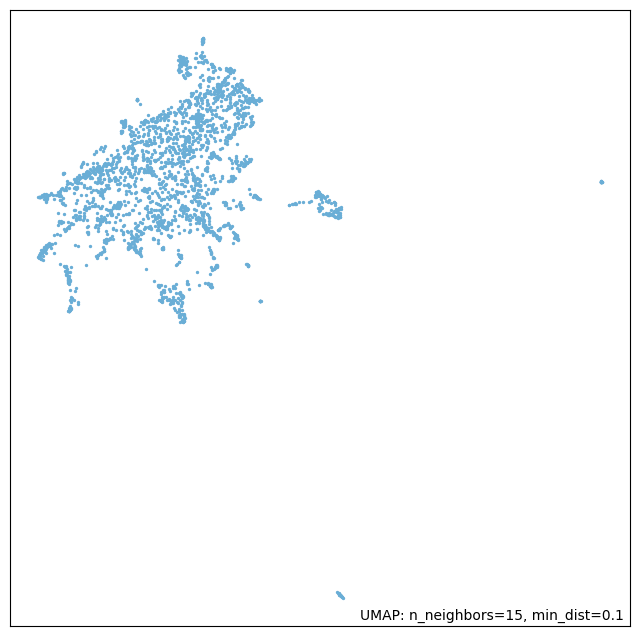

In [51]:
f = umap.plot.points(umap_embeddings)

In [67]:
output_notebook()

Loading BokehJS ...

In [78]:
f = umap.plot.interactive(umap_embeddings, hover_data=pd.DataFrame(filename_chunks, columns=["label"]), point_size=4, alpha=0.8)
show(f)

# Reading ArXiV abstracts
More of an *academic* exercise since there are many websites/tools that do this way better.